# Taget / Error exploration with umap / hdbscan


The general idea of this notebook is to explore where we get high MAE in terms of clusters of the main feature u_in. We use umap and hdbscan to proceed to dimensionnality reduction and clustering. This allow for 2D plot and aggregation of MAE by cluster to priorize wich clusters we have to deal with. Another version of this notebook, including some changes, exploring pressure and MAE is available here (https://www.kaggle.com/lucasmorin/pressure-mae-exploration-with-umap-hdbscan/edit/run/76608318).

# Base construction

In [ ]:
# import numpy as np
# import pandas as pd

# import optuna

# import os 
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# # https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717

# import matplotlib.pyplot as plt
# import tensorflow as tf, gc
# from tensorflow import keras
# import tensorflow.keras.backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
# from tensorflow.keras.optimizers.schedules import ExponentialDecay

# from sklearn.metrics import mean_absolute_error as mae
# from sklearn.preprocessing import RobustScaler, normalize
# from sklearn.model_selection import train_test_split, GroupKFold, KFold

# from IPython.display import display

# import pickle

# DEBUG = False
# TRAIN_MODEL = False

# df_train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
# df_test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
# submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

# if DEBUG:
#     n = 1000
#     df_train = df_train[:80*n]

# def add_features(df):
#     df['area'] = df['time_step'] * df['u_in']
#     df['area'] = df.groupby('breath_id')['area'].cumsum()
    
#     df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
#     df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
#     df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
#     df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
#     df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
#     df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
#     df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
#     df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
#     df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
#     df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
#     df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
#     df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
#     df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
#     df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
#     df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
#     df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
#     df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
#     df = df.fillna(0)
    
#     df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
#     df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
#     df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
#     df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
#     df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
#     df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
#     df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
#     df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
#     df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
#     df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
#     df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
#     df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
#     df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
#     df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
#     df['cross']= df['u_in']*df['u_out']
#     df['cross2']= df['time_step']*df['u_out']
    
#     df['R'] = df['R'].astype(str)
#     df['C'] = df['C'].astype(str)
#     df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
#     df = pd.get_dummies(df)
#     return df

# train = add_features(df_train)
# test = add_features(df_test)

# targets = train[['pressure']].to_numpy().reshape(-1, 80)
# train.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
# test = test.drop(['id', 'breath_id'], axis=1)

# RS = RobustScaler()
# train = RS.fit_transform(train)
# test = RS.transform(test)

# train = train.reshape(-1, 80, train.shape[-1])
# test = test.reshape(-1, 80, train.shape[-1])

# Infer train data to compare

## Import libraries

In [3]:
# For EDA
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

import pickle
import matplotlib.pyplot as plt

In [1]:
import os 

CUDA=1

NAME = '1027_tf_ver5'
OUTPUT_DIR = f'./results/{NAME}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
DATA_DIR = '../input/ventilator-pressure-prediction/'

In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Dense, Dropout, Input, Activation
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply

np.random.seed(42)
tf.random.set_seed(42)

## Load source datasets

In [5]:
train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [6]:
test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


## Feature Engineering

In [7]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"})\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
    
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df


print("Train data...\n")
train = add_features(train_df)

print("\nTest data...\n")
test = add_features(test_df)

del train_df
del test_df
gc.collect()

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


0

In [8]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

print(f"train: {train.shape} \ntest: {test.shape}")

train: (6036000, 64) 
test: (4024000, 64)


In [9]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 64) 
test: (50300, 80, 64) 
targets: (75450, 80)


In [10]:
pressure = targets.squeeze().reshape(-1,1).astype('float32')

P_MIN = np.min(pressure)
P_MAX = np.max(pressure)
P_STEP = (pressure[1] - pressure[0])[0]
print('Min pressure: {}'.format(P_MIN))
print('Max pressure: {}'.format(P_MAX))
print('Pressure step: {}'.format(P_STEP))
print('Unique values:  {}'.format(np.unique(pressure).shape[0]))

del pressure
gc.collect()

Min pressure: -1.8957443237304688
Max pressure: 64.82099151611328
Pressure step: 0.07030248641967773
Unique values:  950


69

## Hardware config

In [11]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 512


## Keras DNN Model

In [12]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    # x_emb = Dense(units=1024)(x_input)
    # x_emb = LayerNormalization()(x_emb)
    # x_emb = Activation('selu')(x_emb)
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z3 = Bidirectional(LSTM(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(LSTM(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z5 = Bidirectional(LSTM(units=64, return_sequences=True))(z51)
    
    y = Dense(units=128, activation='selu')(z2)
    y = Dense(units=128, activation='selu')(y)
    y = Dense(units=128, activation='selu')(y)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5, y])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [13]:
with tf.device(f'/device:GPU:{CUDA}'):
    model = dnn_model()
    model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 64)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 1536)     5117952     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     8392704     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 768)      4328448     bidirectional_1[0][0]            
__________________________________________________________________________________________

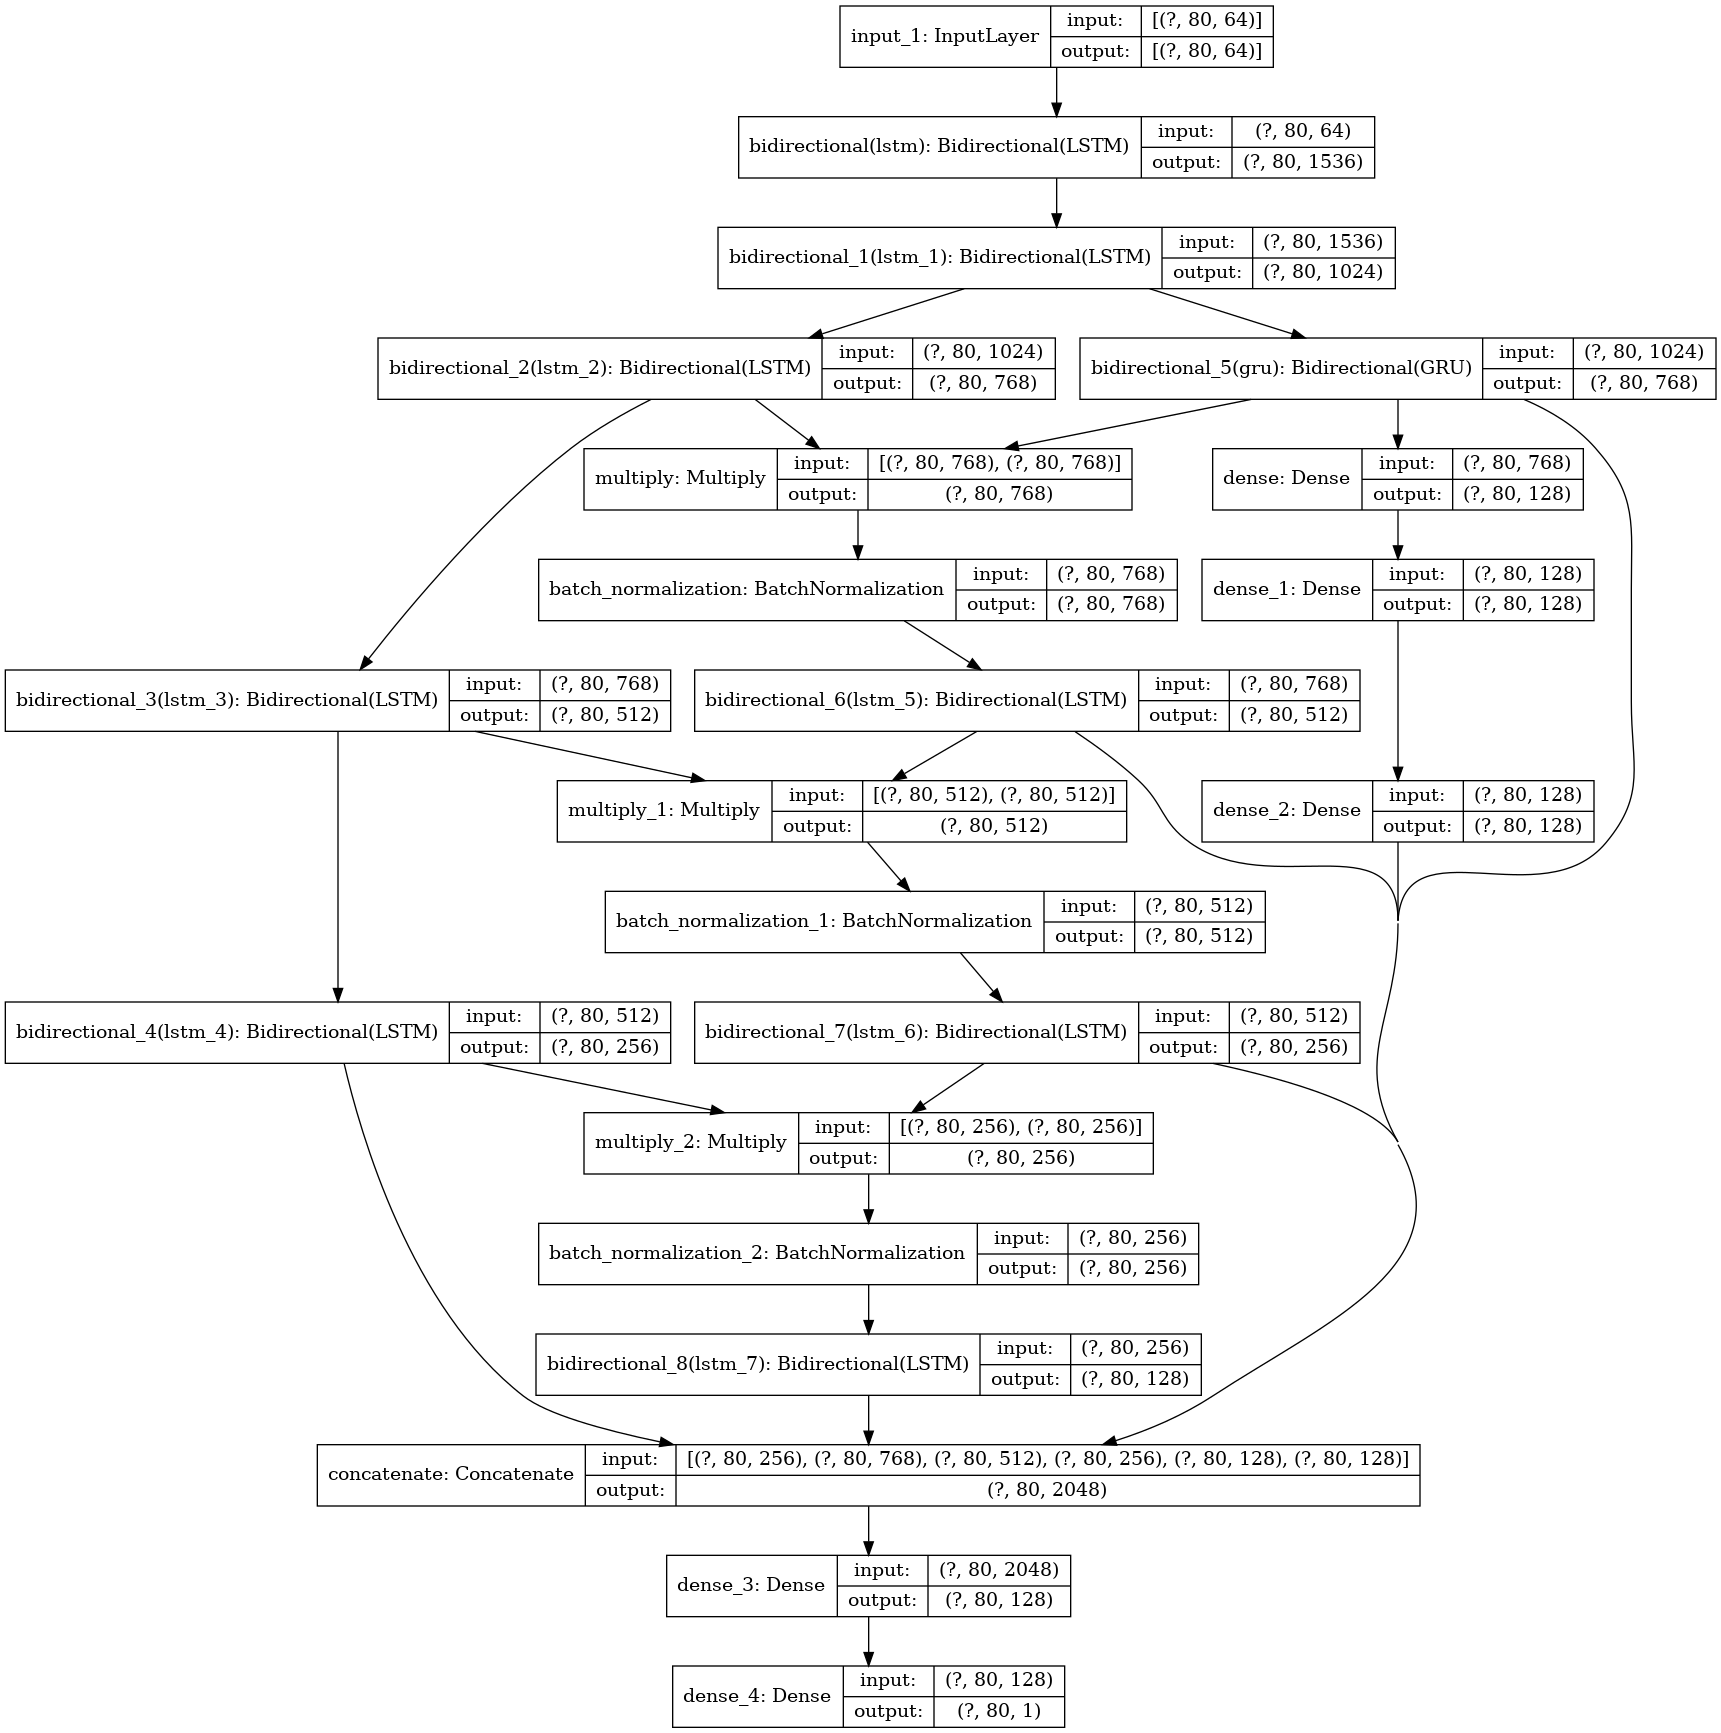

In [14]:
plot_model(
    model, 
    to_file=OUTPUT_DIR+'Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

## inference

In [36]:
with tf.device(f'/device:GPU:{CUDA}'):
    VERBOSE = 1
    test_preds = []
    kf = KFold(n_splits=5, shuffle=True, random_state=2021)

    all_score = 0
    count = 0
    
    y_trues = []
    y_preds = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]

        model = dnn_model()
        model.compile(optimizer="adam", loss="mae")
        model = load_model(OUTPUT_DIR+f'./Bidirect_LSTM_model_2021_{fold+1}C.h5') #options=load_locally

        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        y_trues.extend(y_true.squeeze())
        y_preds.extend(y_pred.squeeze())
        score = mean_absolute_error(y_true, y_pred)
        print(f"Fold-{fold+1} | OOF Score: {score}")
        count += 1
        all_score += score

        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())
                
    print(f'CV Score: {all_score/count:<.4f}')

Fold-1 | OOF Score: 0.1626128874655641
Fold-2 | OOF Score: 0.16484353846380045
Fold-3 | OOF Score: 0.16189404859782702
Fold-4 | OOF Score: 0.16265356261861544
Fold-5 | OOF Score: 0.16189823949329657
CV Score: 0.1628


In [39]:
DEBUG = False

if DEBUG: n=1000
else: n=75450
    
df = pd.DataFrame({'target': y_trues, 'preds': y_preds, 'id': [i+1 for i in range(n) for e in range(80)]})
preds_by_id = np.array(y_preds).reshape(-1, 80)
df['u_out_mask'] = (train[:,:,2] == -1).flatten()
df['error'] = np.abs(df['target']-df['preds'])
df_masked = df.mask(~df['u_out_mask'])
MAE_id = df_masked.groupby('id').agg(np.nanmean)['error']

In [ ]:
MAE_file = "MAE_id.pkl"

with open(MAE_file,'wb') as f:
    pickle.dump(MAE_id, f)
    
MAE_id.to_csv("MAE_id.csv", index=False)

# Basic Exploration

In [ ]:
MAE_id.describe()

In [ ]:
np.log(MAE_id).hist(bins=100)

In [ ]:
MAE_id_sorted = MAE_id.sort_values(ascending=False)

# worst predictions

In [ ]:
for i in MAE_id_sorted.index[:10]:
    ind = np.int(i)
    ind_labels = (MAE_id.index.values == i)
    
    print('cluster:'+str(i) + ' MAE: '+str(np.round(MAE_id_sorted[i],3)))

    plt.figure(figsize=(24,8))
    
    plt.subplot(1, 3, 1)
    plt.plot(train[ind_labels,:,1].transpose());
    plt.title('u_in')
    
    plt.subplot(1, 3, 2)
    plt.plot(targets[ind_labels].transpose(), label='target');
    plt.plot(preds_by_id[ind_labels].transpose(), label='preds');
    plt.legend()
    plt.title('pressure')
    
    plt.subplot(1, 3, 3)
    plt.plot((targets[ind_labels] - preds_by_id[ind_labels]).transpose());
    plt.title('error')
    
    plt.show()

LTSM seems to be able to predict weird noise, but has some constant error on some ids. However such errors seems rather rare. The instance with 15 MAE only account for 0.0002 global MAE. We must find if some clusters of output have more important global error (less individual MAE but high number of instances).

# Explaining worst predictions

Worst errors seems to come from a shift in values. 
From the discussion here: https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/278935 we see that most of the time a change in R and C only translate in some shift. So my main hypothese for explaining the worst predictions was some noise in R & C that translate into shiting the predictions. See the discussion here:https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/280356

One way to test this hypothese was to try and switch R & C values and see if we get better predictions.
With at least 3-4 values of the top 10 MAE explained by a shift in C, this appears something to be worth investigating more. Maybe we can try to predict better R and C from u_in values.

In [ ]:
df_trainw = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
df_trainw['breath_id'] = [i+1 for i in range(75450) for e in range(80)]

for i in MAE_id_sorted.index[:10]:
    
    ind = np.int(i)
    ind_labels = (MAE_id.index.values == i)
    
    print(ind)
    
    df = df_trainw[df_trainw.breath_id == np.int(i)].reset_index(drop=True)

    print('original R: '+str(df.R.unique()[0]))
    print('original C: '+str(df.C.unique()[0]))
    
    
    basew_all = pd.DataFrame()

    for R in [20, 50,  5]:
        for C in [50, 20, 10]:
            basew_temp = df.copy()
            basew_temp['R']=R
            basew_temp['C']=C
            basew_temp['breath_id'] = basew_temp['breath_id']*100000 + C * 1000 + R
            basew_all = basew_all.append(basew_temp)
    
    trainw = add_features(basew_all)
    trainw.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
    trainw = RS.transform(trainw)
    trainw = trainw.reshape(-1, 80, trainw.shape[-1])
    
    gpu_strategy = tf.distribute.get_strategy()

    with gpu_strategy.scope():
        kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
        trainw_preds = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
            if fold>0:
                break
            K.clear_session()
            print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
            checkpoint_filepath = f"folds{fold}.hdf5"
            model = keras.models.load_model('../input/finetune-of-tensorflow-bidirectional-lstm/'+checkpoint_filepath)
            trainw_preds.append(model.predict(trainw, batch_size=BATCH_SIZE, verbose=2).squeeze().reshape(-1, 1).squeeze())
            del model
            gc.collect()
    
    preds = trainw_preds[0]
    
    plt.figure(figsize=(16,8))
    
    plot_max = np.max([np.max(preds), np.max(df.pressure), np.max(preds_by_id[ind_labels])])
    plot_min = np.min([np.max(preds), np.min(df.pressure), np.min(preds_by_id[ind_labels])])
    
    
    plt.subplot(1, 2, 1)
    plt.plot(df.pressure, label='target');
    plt.plot(preds_by_id[ind_labels].transpose(), label='preds');
    plt.ylim((np.min(plot_min), np.max(plot_max))) 
    plt.legend()
    plt.title('pressure')
    
    plt.subplot(1, 2, 2)
    plt.plot(preds.reshape(-1,80).transpose(), label = ('R '+basew_all.R.astype('str') +' - C '+ basew_all.C.astype('str')).unique());
    plt.ylim((np.min(plot_min), np.max(plot_max))) 
    plt.title('predicted_pressure')
    plt.legend()
    plt.show()
    
del trainw

# UMAP / Hdbscan

In [ ]:
!mkdir -p /tmp/pip/cache/
!cp ../input/hdbscan0827-whl/hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl /tmp/pip/cache/
!pip install --no-index --find-links /tmp/pip/cache/ hdbscan

# exploration on u_in - UMAP Embedding - hdbscan clustering

As the idea is to observe the main feature, we embed u_in with umap then we fit hdbscan on the embedding. Maybe better to fit hdbscan on the original data...

In [ ]:
%%time

import hdbscan
import umap

n=75450

# Switch to do the exploration on pressure
X = train[:,:,1]
#X = targets

reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(X)
clusterer = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size = 50).fit(embedding)
u, counts = np.unique(clusterer.labels_, return_counts=True)

print(u)
print(counts)

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=clusterer.labels_, edgecolors='none', cmap='jet');

Doesn't seems to good of a clustering... there seems to be lot of 'outliers'.

# Plot error - log_scale

In [ ]:
import matplotlib.colors as colors
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=MAE_id[:n], edgecolors='none', cmap='jet', norm=colors.LogNorm(vmin=MAE_id[:n].quantile(0.05), vmax=MAE_id[:n].quantile(0.95)));
plt.colorbar();

# MAE by cluster

not exact as mean of MAE is not exactly the evaluation metric (due to u_out not starting at the same time), but should be ok for exploration.

In [ ]:
MAE_by_cluster = pd.DataFrame({'cluster':clusterer.labels_,'MAE':MAE_id})

MAE_cluster = MAE_by_cluster.groupby('cluster').agg(np.sum)['MAE']

#remove some base MAE, then divide by gloabl number
MAE_cluster_global = (MAE_cluster - counts * 0.1)/counts.sum()
MAE_cluster_global = MAE_cluster_global.sort_values(ascending=False)

In [ ]:
MAE_cluster_global

In [ ]:
for i in MAE_cluster_global.index[:10]:
    ind_labels = (clusterer.labels_ == i)
    print('cluster:'+str(i) + ' Global MAE: '+str(np.round(MAE_cluster_global[i],4)) + ' count: '+str(np.sum(ind_labels)))

    plt.figure(figsize=(24,6))
    
    plt.subplot(1, 4, 1)
    plt.scatter(embedding[:, 0], embedding[:, 1], s=5+100*ind_labels, c=ind_labels, edgecolors='none', cmap='viridis');
    plt.title('position')
    
    plt.subplot(1, 4, 2)
    plt.plot(train[ind_labels,:,1].transpose());
    plt.title('u_in')
    
    plt.subplot(1, 4, 3)
    plt.plot(targets[ind_labels].transpose());
    plt.title('pressure')
    
    plt.subplot(1, 4, 4)
    plt.plot((targets[ind_labels] - preds_by_id[ind_labels]).transpose());
    plt.title('error: target-preds')
    
    plt.show()

We have found some clusters with high MAE. The cluster 4 with 0.52 MAE and 360 instances account for 0.002 global MAE, while a single instance with 15 MAE account for 0,0002 of global MAE. It appears to be 10 times more important to deal with this cluster than to deal with the higher individual MAE. 

Regarding specific clusters and how to deal with them, some spike of errors seems concentrated. We might want to try some adapted features. 

# Study with u_out masking

We mask u_in with ~u_out to see if we get a better clustering.

In [ ]:
%%time

import hdbscan
import umap

n=75450

# Switch to do the exploration on pressure
X = train[:,:,1]
X_mask = X*((train[:,:,2]==-1)+0)
#X = targets

reducer_mask = umap.UMAP(random_state=42, n_components=2)
embedding_mask = reducer_mask.fit_transform(X_mask)
clusterer_mask = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size = 50).fit(embedding_mask)
u_mask, counts_mask = np.unique(clusterer_mask.labels_, return_counts=True)

print(u_mask)
print(counts_mask)

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding_mask[:, 0], embedding_mask[:, 1], s=5, c=clusterer_mask.labels_, edgecolors='none', cmap='jet');

In [ ]:
import matplotlib.colors as colors
plt.figure(figsize=(10, 8))
plt.scatter(embedding_mask[:, 0], embedding_mask[:, 1], s=5, c=MAE_id[:n], edgecolors='none', cmap='jet', norm=colors.LogNorm(vmin=MAE_id[:n].quantile(0.05), vmax=MAE_id[:n].quantile(0.95)));
plt.colorbar();

# Study by R and C

In [ ]:
df_rc = df_train[['breath_id','R','C']].groupby('breath_id').agg(np.min)

for r in [5,20,50]:
    for c in [10,20,50]:
        
        print('r: '+str(r)+', c: '+str(c))
        ind_rc = (df_rc.R==r) & (df_rc.C==c)

        X = targets[ind_rc]
        #u_in
        X_train = train[ind_rc,:,1]
        X_targets = targets[ind_rc]
        X_preds = preds_by_id[ind_rc]

        reducer = umap.UMAP(random_state=42, n_components=2)
        
        # switch to embed on u_in (not tested)
        embedding = reducer.fit_transform(X_train)
        #embedding = reducer.fit_transform(X)

        clusterer = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size = 20).fit(embedding)
        u, counts = np.unique(clusterer.labels_, return_counts=True)

        plt.figure(figsize=(20, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=clusterer.labels_, edgecolors='none', cmap='jet');
        plt.title('clusters')
        plt.subplot(1, 2, 2)
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=MAE_id[ind_rc.values], edgecolors='none', cmap='jet', norm=colors.LogNorm(vmin=1e-2, vmax=1e0));
        plt.title('MAE')
        plt.colorbar();
        plt.show();
        
        
        MAE_by_cluster = pd.DataFrame({'cluster':clusterer.labels_,'MAE':MAE_id[ind_rc.values]})
        MAE_cluster = MAE_by_cluster.groupby('cluster').agg(np.sum)['MAE']
        #remove some base MAE, then divide by gloabl number
        MAE_cluster_global = (MAE_cluster - counts * 0.15)/counts.sum()
        MAE_cluster_global = MAE_cluster_global.sort_values(ascending=False)
        
        
        for i in MAE_cluster_global.index[:3]:
            ind_labels = (clusterer.labels_ == i)
            print('cluster:'+str(i) + ' Global MAE: '+str(np.round(MAE_cluster_global[i],4)) + ' count: '+str(np.sum(ind_labels)))

            plt.figure(figsize=(24,6))
            plt.subplot(1, 4, 1)
            plt.scatter(embedding[:, 0], embedding[:, 1], s=5+100*ind_labels, c=ind_labels, edgecolors='none', cmap='viridis');
            plt.title('position')
            plt.subplot(1, 4, 2)
            plt.plot(X_train[ind_labels,:].transpose());
            plt.title('u_in')
            plt.subplot(1, 4, 3)
            plt.plot(X_targets[ind_labels].transpose());
            plt.title('pressure')
            plt.subplot(1, 4, 4)
            plt.plot((X_targets[ind_labels] - X_preds[ind_labels]).transpose());
            plt.title('error: target-preds')
            plt.show()
        
        
        
        

Some observations :

    - High Errors appear quite clustered for some R&C values. 
    
    - This does seems exploitable as we identify some cluster that seems to be responsible for more than 0.01 MAE gloably.
    
    - There might be some work to get better parameters for hdbscan (the three clusters for r: 5, c: 50 should be one). 
    
    - From the u_in graph and further inverstigation (coloring by first and last u_in - see below) the weirdest cluster appears linked to first and last values of u_in. 

# Role of u_in_first, u_in_last

In [ ]:
df_rc = df_train[['breath_id','R','C']].groupby('breath_id').agg(np.min)

for r in [20]:
    for c in [50]:
        
        print('r: '+str(r)+', c: '+str(c))
        ind_rc = (df_rc.R==r) & (df_rc.C==c)

        X = targets[ind_rc]
        #u_in
        X_train = train[ind_rc,:,1]
        X_targets = targets[ind_rc]
        X_preds = preds_by_id[ind_rc]

        reducer = umap.UMAP(random_state=42, n_components=2)
        embedding = reducer.fit_transform(X)

        clusterer = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size = 20).fit(embedding)
        u, counts = np.unique(clusterer.labels_, return_counts=True)

        plt.figure(figsize=(20, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=clusterer.labels_, edgecolors='none', cmap='jet');
        plt.title('clusters')
        plt.subplot(1, 2, 2)
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=MAE_id[ind_rc.values], edgecolors='none', cmap='jet', norm=colors.LogNorm(vmin=1e-2, vmax=1e0));
        plt.title('MAE')
        plt.colorbar();
        plt.show();
        
        plt.figure(figsize=(20, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=X_train[:,1], edgecolors='none', cmap='jet');
        plt.title('u_in_first')
        plt.colorbar();
        plt.subplot(1, 2, 2)
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=X_train[:,-1], edgecolors='none', cmap='jet');
        plt.title('u_in_last')
        plt.colorbar();
        plt.show();

 My idea was to  get the first and last values separately. I implemented some dedicated functions. But it doesn't exactly seems optimal to build constant time series for LSTM. Maybe we can build a second head that would take individual time series features. From my time series feature engineering notebook here :https://www.kaggle.com/lucasmorin/time-series-agregation-functions:

In [ ]:
get_first = lambda x: x.iloc[0]
get_first.__name__ = 'get_first'

get_last = lambda x: x.iloc[-1]
get_last.__name__ = 'get_last'

get_first_fn = [get_first,get_last]

create_feature_dict = {
    'u_in': get_first_fn,
}

train_features = df_train.groupby('breath_id').agg(create_feature_dict)
train_features.columns = ['_'.join(col) for col in train_features.columns]

train_features.head()